 # Automated Image Classification using Advanced Deep Learning Models

 Group number 2: Renee DeMaio

 The goal for this Lab is it to provide you understanding of the various deep learning models that we will be using in your project(s). In this Lab we will implement VGG Architecture over CUB200-2011 dataset:

 The CUB200-2011 dataset can be found on its [website](https://paperswithcode.com/dataset/cub-200-2011). We can either use the data zip file or import it using  [Kaggle](https://www.kaggle.com) and [kaggle-api](https://github.com/Kaggle/kaggle-api) which needs to be installed with `pip install kaggle`. I would prefer all of you do this using Google Colab. This will also help you with Last 3 Labs.

  ## Data Preprocessing
 ### Downloading and extracting custom datasets
 ### Loading custom datasets

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import Libraries and Set Random Seed

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, top_k_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == "cuda":
    print(torch.cuda.get_device_name(0))
    print("Memory Usage:")
    print("Allocated:", round(torch.cuda.memory_allocated(0)/1024**3, 1), "GB")
    print("Cached:", round(torch.cuda.memory_reserved(0)/1024**3, 1), "GB")

Using device: cuda
Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached: 0.0 GB


In [3]:
def set_seed(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(7598)

In [4]:
# Set Data folders, TensorDatasets and DataLoaders for the datasets

import os
import shutil
from tqdm import tqdm

source_dir = "/content/drive/MyDrive/DSAN_6500/project/chestxray14_dataset/sampled"
train_dir = "/content/drive/MyDrive/DSAN_6500/project/chestxray14_dataset/sampled/train"
test_dir = "/content/drive/MyDrive/DSAN_6500/project/chestxray14_dataset/sampled/test"
val_dir = "/content/drive/MyDrive/DSAN_6500/project/chestxray14_dataset/sampled/val"
output_dir = "/content/drive/MyDrive/DSAN_6500/project/chestxray14_dataset/sampled/output_images"


 ### Calculating the mean and std for normalization on custom datasets


Commented this out because it takes two hours to run on colab. Results are in the transformations below.

In [5]:
# from pathlib import Path
# import cv2
# import numpy as np
# from tqdm import tqdm

# train_dir = Path(r'/content/drive/MyDrive/DSAN_6500/lab_7to9/cub2002011_dataset/train')
# files = list(train_dir.rglob('*.png'))

# mean = np.array([0., 0., 0.])
# stdTemp = np.array([0., 0., 0.])
# std = np.array([0., 0., 0.])

# numSamples = len(files)

# for i in range(numSamples):
#     im = cv2.imread(str(files[i]))
#     im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#     im = im.astype(float) / 255.

#     for j in range(3):
#         mean[j] += np.mean(im[:, :, j])

# mean = (mean / numSamples)

# for i in range(numSamples):
#     im = cv2.imread(str(files[i]))
#     im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#     im = im.astype(float) / 255.
#     for j in range(3):
#         stdTemp[j] += ((im[:, :, j] - mean[j]) ** 2).sum() / (im.shape[0] * im.shape[1])

# std = np.sqrt(stdTemp / numSamples)

# print(f"Calculated Mean: {mean}")
# print(f"Calculated Standard Deviation: {std}")

### Loading transforms to augment and normalize our data

In [6]:
from PIL import Image

batch_size = 64
numworkers = 2

# the below function tranforms and normalises the data

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.49154367, 0.49154367, 0.49154367], [0.25023263, 0.25023263, 0.25023263])
])

train_dataset = datasets.ImageFolder(train_dir, transform = transform)
test_dataset = datasets.ImageFolder(test_dir, transform = transform)
validation_dataset = datasets.ImageFolder(val_dir, transform = transform)

train_loader = DataLoader(train_dataset,
                          batch_size = batch_size,
                          shuffle = True,
                          num_workers = numworkers)

test_loader = DataLoader(test_dataset,
                          batch_size = batch_size,
                          shuffle = False,
                          num_workers = numworkers)

validation_loader = DataLoader(validation_dataset,
                          batch_size = batch_size,
                          shuffle = False,
                          num_workers = numworkers)

  ## Defining a Convolutional Neural Network
 ### Defining the VGG blocks
 ### Defining a CUB200-2011 VGG model

In [7]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc = "Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    return epoch_loss

In [8]:
def compute_metrics(labels, predictions, probs):
    metrics = {
        "Accuracy" : accuracy_score(labels, predictions),
        "Top-5 Accuracy" : top_k_accuracy_score(labels, probs, k = 5),
        "Macro Precision" : precision_score(labels, predictions, average = "macro"),
        "Weighted Precision" : precision_score(labels, predictions, average = "weighted"),
        "Macro Recall" : recall_score(labels, predictions, average = "macro"),
        "Weighted Recall" : recall_score(labels, predictions, average = "weighted"),
        "Weighted F1-Score" : f1_score(labels, predictions, average = "weighted"),
        "Weighted AUC Score" : roc_auc_score(labels, probs, multi_class = "ovr", average = "weighted"),
        "Weighted Mean Average Precision" : average_precision_score(labels, probs, average = "weighted")
    }

    return metrics

In [9]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc = "Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(nn.Softmax(dim = 1)(outputs).cpu().numpy())

    epoch_loss = running_loss / len(data_loader.dataset)
    accuracy = 100 * correct / total

    metrics = compute_metrics(all_labels, all_predictions, all_probs)

    return epoch_loss, accuracy, metrics

In [10]:
from typing import Any

class EarlyStopping:
    def __init__(self, patience = 5, verbose = False, delta = 0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_loss = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            if self.best_loss is not None:
                print(f"Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}). Saving model ...")
            else:
                print(f"Saving model with validation loss {val_loss:.6f} ...")
        torch.save(model.state_dict(), "best_model.pth")
        self.best_loss = val_loss

 ## Training a Convolutional Neural Network
 ### Loading a pre-trained model
 ### Loading pre-trained model parameters into a defined model
 ### Learning rate finder
 ### Discriminative fine-tuning
 ### One cycle learning rate scheduler

In [12]:
from torchvision.models import GoogLeNet_Weights

googlenet = torchvision.models.googlenet(weights = GoogLeNet_Weights.IMAGENET1K_V1)

in_features = googlenet.fc.in_features

googlenet.fc = nn.Linear(in_features=in_features, out_features=15, bias=True)

cuda = torch.cuda.is_available()

if cuda:
 googlenet.cuda()

print(googlenet)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [13]:
optimizer = optim.AdamW(params = googlenet.parameters(),   lr= 1e-3)
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = nn.CrossEntropyLoss()

In [14]:
num_epochs = 40
patience = 5
early_stopping = EarlyStopping(patience = patience, verbose = True)

train_losses = []
val_losses = []
val_accuracies = []
metrics_list = []

for epoch in range(num_epochs):
    train_loss = train(googlenet, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, metrics = evaluate(googlenet, validation_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    metrics_list.append(metrics)

    print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    for metric_name, metric_value in metrics.items():
        print(f"{metric_name} : {metric_value:.4f}")

    early_stopping(val_loss, googlenet)

    if early_stopping.early_stop:
        print("Early stopping")
        break

Evaluating: 100%|██████████| 23/23 [09:31<00:00, 24.84s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1/40, Train Loss: 1.8848, Val Loss: 2.1770, Val Accuracy: 42.98%
Accuracy : 0.4298
Top-5 Accuracy : 0.8144
Macro Precision : 0.0610
Weighted Precision : 0.2432
Macro Recall : 0.0747
Weighted Recall : 0.4298
Weighted F1-Score : 0.2778
Weighted AUC Score : 0.6829
Weighted Mean Average Precision : 0.3545
Saving model with validation loss 2.176982 ...


Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.34it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2/40, Train Loss: 1.8128, Val Loss: 1.8285, Val Accuracy: 44.04%
Accuracy : 0.4404
Top-5 Accuracy : 0.8151
Macro Precision : 0.0983
Weighted Precision : 0.3034
Macro Recall : 0.0921
Weighted Recall : 0.4404
Weighted F1-Score : 0.3321
Weighted AUC Score : 0.7157
Weighted Mean Average Precision : 0.3764
Validation loss decreased (2.176982 --> 1.828456). Saving model ...


Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.34it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3/40, Train Loss: 1.7645, Val Loss: 1.8374, Val Accuracy: 44.32%
Accuracy : 0.4432
Top-5 Accuracy : 0.8059
Macro Precision : 0.0975
Weighted Precision : 0.3032
Macro Recall : 0.0991
Weighted Recall : 0.4432
Weighted F1-Score : 0.3343
Weighted AUC Score : 0.7106
Weighted Mean Average Precision : 0.3689
EarlyStopping counter: 1 out of 5


Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.32it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4/40, Train Loss: 1.7383, Val Loss: 1.9743, Val Accuracy: 44.32%
Accuracy : 0.4432
Top-5 Accuracy : 0.8236
Macro Precision : 0.1433
Weighted Precision : 0.3166
Macro Recall : 0.0936
Weighted Recall : 0.4432
Weighted F1-Score : 0.3161
Weighted AUC Score : 0.7135
Weighted Mean Average Precision : 0.3748
EarlyStopping counter: 2 out of 5


Evaluating: 100%|██████████| 23/23 [00:16<00:00,  1.36it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5/40, Train Loss: 1.7043, Val Loss: 1.8306, Val Accuracy: 44.53%
Accuracy : 0.4453
Top-5 Accuracy : 0.8207
Macro Precision : 0.1572
Weighted Precision : 0.3461
Macro Recall : 0.1188
Weighted Recall : 0.4453
Weighted F1-Score : 0.3527
Weighted AUC Score : 0.7290
Weighted Mean Average Precision : 0.3839
EarlyStopping counter: 3 out of 5


Evaluating: 100%|██████████| 23/23 [00:17<00:00,  1.34it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6/40, Train Loss: 1.6814, Val Loss: 1.8300, Val Accuracy: 44.60%
Accuracy : 0.4460
Top-5 Accuracy : 0.8278
Macro Precision : 0.1756
Weighted Precision : 0.3476
Macro Recall : 0.1294
Weighted Recall : 0.4460
Weighted F1-Score : 0.3663
Weighted AUC Score : 0.7241
Weighted Mean Average Precision : 0.3849
EarlyStopping counter: 4 out of 5


Evaluating: 100%|██████████| 23/23 [00:16<00:00,  1.36it/s]

Epoch: 7/40, Train Loss: 1.6450, Val Loss: 1.9841, Val Accuracy: 44.46%
Accuracy : 0.4446
Top-5 Accuracy : 0.8342
Macro Precision : 0.1519
Weighted Precision : 0.3366
Macro Recall : 0.1020
Weighted Recall : 0.4446
Weighted F1-Score : 0.3314
Weighted AUC Score : 0.7259
Weighted Mean Average Precision : 0.3857
EarlyStopping counter: 5 out of 5
Early stopping



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 ## Evaluating a Convolutional Neural Network
 ### Fine-tuning a pre-trained model to achieve ~80% top-1 accuracy and ~95% top-5 accuracy on a dataset with 200 classes and only 60 examples per class
 ### Visualizing our data in lower dimensions with PCA and t-SNE
 ### Viewing the learned weights of our model

Using the pre-trained model

In [16]:
metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv("/content/drive/MyDrive/DSAN_6500/project/chestxray14_dataset/googlenet_metrics.csv", index = False)

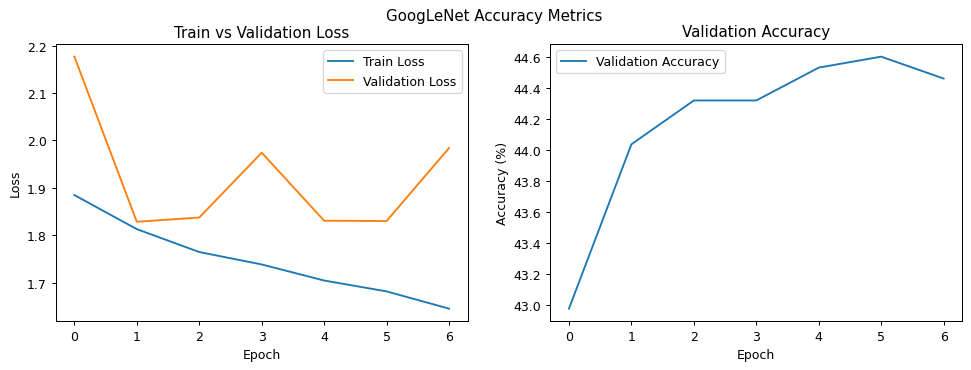

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize = (13, 4), dpi = 90)
plt.subplot(1, 2, 1)
plt.plot(train_losses, label = "Train Loss")
plt.plot(val_losses, label = "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label = "Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.legend()

plt.suptitle("GoogLeNet Accuracy Metrics")
plt.savefig("/content/drive/MyDrive/DSAN_6500/project/chestxray14_dataset/output_images/googlenet_metrics.jpg", dpi = 300)

plt.show()

In [18]:
test_loss, test_accuracy, test_metrics = evaluate(googlenet, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
for metric_name, metric_value in test_metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

Evaluating: 100%|██████████| 34/34 [14:30<00:00, 25.61s/it]

Test Loss: 1.9898, Test Accuracy: 43.83%
Accuracy: 0.4383
Top-5 Accuracy: 0.8235
Macro Precision: 0.1459
Weighted Precision: 0.3166
Macro Recall: 0.0963
Weighted Recall: 0.4383
Weighted F1-Score: 0.3220
Weighted AUC Score: 0.7309
Weighted Mean Average Precision: 0.3827



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 ### Viewing our model's mistakes

In [19]:
def display_random_images(model, test_dataset, dataset_classes, num_images = 12):
    model.eval()
    indices = random.sample(range(len(test_dataset)), num_images)
    images, labels = zip(*[test_dataset[i] for i in indices])
    images = torch.stack(images).to(device)
    labels = torch.tensor(labels).to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    images = images.cpu().numpy().transpose((0, 2, 3, 1))
    images = images * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    images = np.clip(images, 0, 1)

    fig, axes = plt.subplots(4, 3, figsize = (12, 12))
    axes = axes.flatten()
    for img, true_label, pred_label, ax in zip(images, labels, predicted, axes):
        ax.imshow(img)
        ax.set_title(f"True: {dataset_classes[true_label]} \nPred: {dataset_classes[pred_label]}", color = '#009878' if true_label == pred_label else "#9C3839")
        ax.axis("off")

    plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/DSAN_6500/project/chestxray14_dataset/output_images/googlenet_test_images.jpg", dpi = 300)
    plt.show()

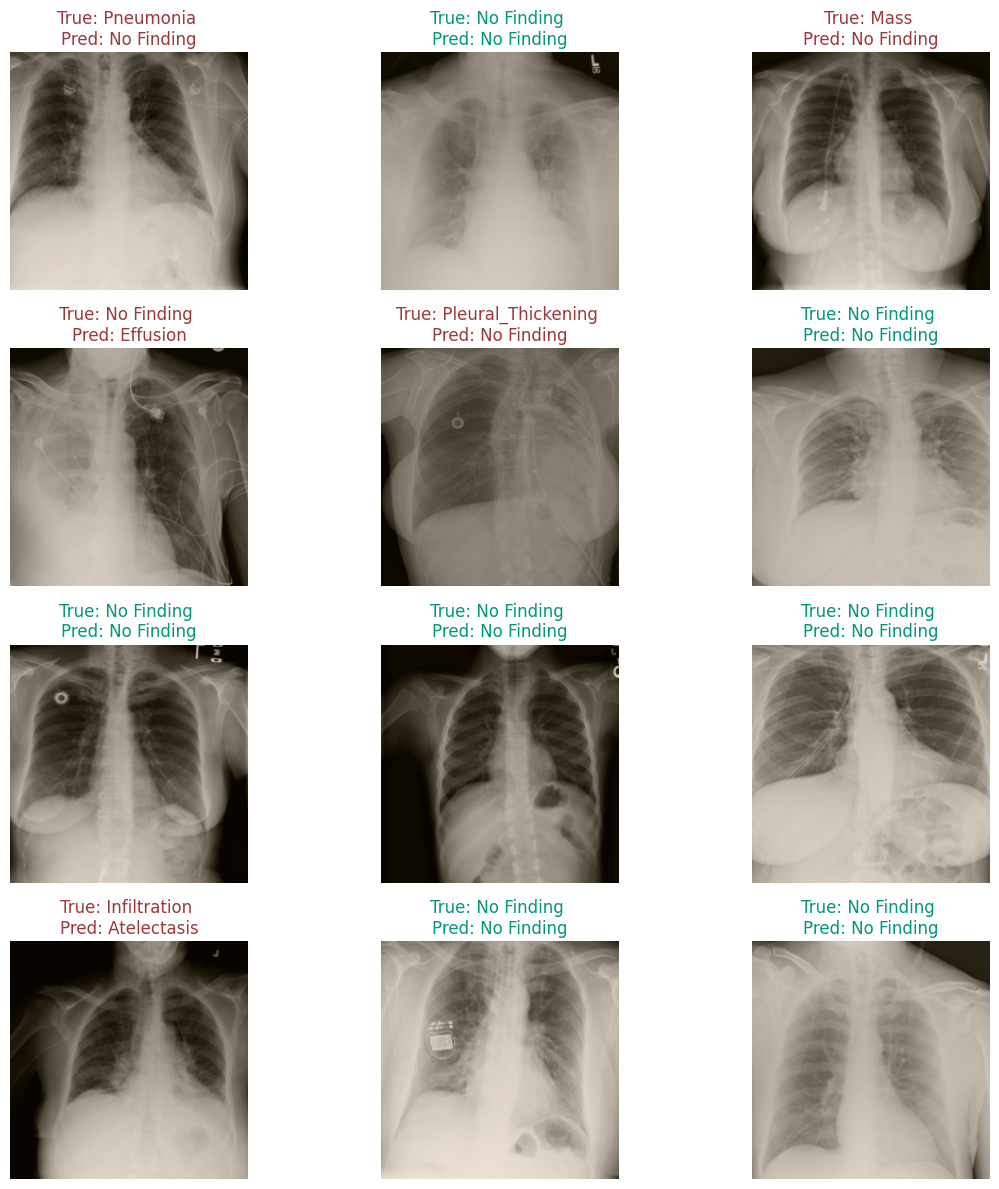

In [20]:
display_random_images(googlenet, test_dataset, test_dataset.classes)

### Confusion Matrix


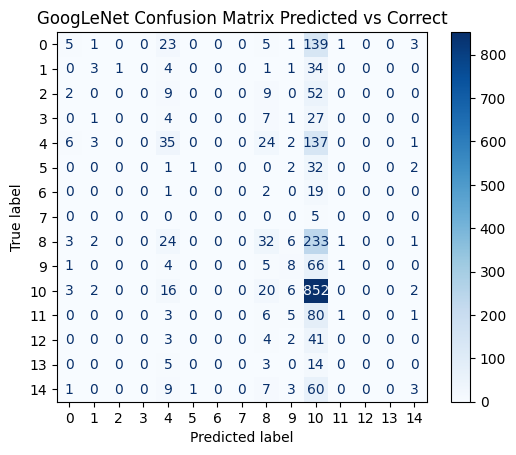

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
googlenet.to(device)

googlenet.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = googlenet(inputs)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.title("GoogLeNet Confusion Matrix Predicted vs Correct")
plt.savefig("/content/drive/MyDrive/DSAN_6500/project/chestxray14_dataset/output_images/googlenet_cm.jpg", dpi = 300)
plt.show()